# CO Data Processing and Analysis Notebook

This notebook processes netCDF files, filters, and cleans the data, and provides basic visualization. Follow the steps and instructions provided.

## Import Necessary Libraries

In [1]:
import numpy as np
import dask.array as da
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from pyresample import geometry, kd_tree
from pyresample.geometry import AreaDefinition
from pyresample.bucket import BucketResampler
import cartopy.crs as ccrs
import os
import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pyproj')


## Define Helper Functions

These functions will help in filtering, cleaning, and processing the data.

In [2]:
# Import custom data processing functions
from data_processing import filter_and_clean_data, process_files, regrid_and_reproject_data, combine_data, plot_reprojected_data

## Usage Instructions

## Define Parameters and Directories

Specify the parameters and directories needed for the data processing.


In [3]:
data_directory = "CO_data/"  # Update to your data directory
placeholder_value = 9.969209968386869e+36  # Check placeholder value from metadata
variable_name = 'carbonmonoxide_total_column' # Check variable name from file metadata
qa_threshold = 0.5
qa_variable_name = 'qa_value'  # Update this to the QA variable name if different
min_value = None  # Optional, set to None if not needed
conversion_factor = 6.022140857e+19  # Check conversion factor from metadata

## Define Area Definition

From pyresample https://pyresample.readthedocs.io/en/latest/howtos/geo_def.html#areadefinition

In [4]:
area_id = 'arctic_circle'
description = 'Arctic Circle region grid'
proj_id = 'north_polar_stereographic'
projection = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +datum=WGS84 +units=m +no_defs'
width = 100 # number of pixels
height = 100 # number of pixels
area_extent = (-4511076.79, -4511076.79, 4511076.79, 4511076.79)

area_def = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

## Step 1: Process the Files

Provide the directory containing your netCDF files and run the following cell to process the files.
This function processes netCDF files in a directory and organizes them by date.


    Parameters:
    - data_directory: str, directory containing netCDF files

    Returns:
    - daily_datasets: dict, datasets organized by date

In [5]:
daily_datasets = process_files(data_directory)
print("Files processed and organized by date.")

Files processed and organized by date.


## Step 2: Combine Data

Combine data from different files and dates.

In [6]:
# Combine data with conversion factor applied within the function
combined_data = combine_data(daily_datasets, variable_name, qa_variable_name, conversion_factor)
print("Data combination completed.")

/opt/anaconda3/envs/dippa/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Data combination successful for date 2020-06-06
Data combination successful for date 2020-06-05
Data combination successful for date 2020-06-04
Data combination successful for date 2020-06-02
Data combination successful for date 2020-06-01
Data combination successful for date 2020-06-03
Data combination completed.


## Step 3: Filter data
This function filters and cleans the data based on quality and placeholder values.

    Filters and cleans the data based on quality and placeholder values.

    Parameters:
    - combined_data: dict, combined data from different dates
    - placeholder_value: value to be replaced with NaN
    - variable_name: name of the variable to be filtered
    - qa_threshold: threshold for quality assurance
    - min_value: minimum value to filter the data (optional)

    Returns:
    - filtered_data: dict, filtered data

In [7]:
filtered_data = filter_and_clean_data(combined_data, placeholder_value, variable_name, qa_threshold, min_value)
print("Data filtered and cleaned.")

Data filtered and cleaned.


## Step 4: Reproject and Plot Data

Reproject the data and plot the results.

Methods:

'nearest': Uses the nearest neighbor interpolation to resample the data.

'average': Averages the data values within the defined grid cells.

'count': Counts the number of non-NaN observations within each grid cell.

'sum': Sums the data values within each grid cell.

'min': Finds the minimum data value within each grid cell.

'max': Finds the maximum data value within each grid cell.

'median': Computes the median data value within each grid cell.

'abs_max': Finds the absolute maximum value within each grid cell.

Pyresample kd.tree: https://pyresample.readthedocs.io/en/latest/howtos/swath.html#pyresample-kd-tree

& bucket: https://pyresample.readthedocs.io/en/latest/howtos/swath.html#pyresample-bucket

In [8]:
# Reproject the data
reprojected_datasets = {}
for date, data in filtered_data.items():
    reprojected_data, lons_new, lats_new = regrid_and_reproject_data(
        data["latitude"], data["longitude"], data[variable_name], area_def, method='average')
    
    reprojected_datasets[date] = {
        'lons_new': lons_new,
        'lats_new': lats_new,
        'reprojected_data': reprojected_data
    }

## Step 5: Plot Data for a Specific Date

Provide the date, colormap, and value range for which you want to plot the reprojected data.

In [16]:
# Assuming reprojected_data is a Dask array

# Compute the max and min values of the reprojected data
max_value = np.nanmax(reprojected_data).compute()
min_value = np.nanmin(reprojected_data).compute()

print(f"Max value after reprojecting: {max_value}")
print(f"Min value after reprojecting: {min_value}")

Max value after reprojecting: 2.4837351944948285e+18
Min value after reprojecting: 9.424519129010074e+17


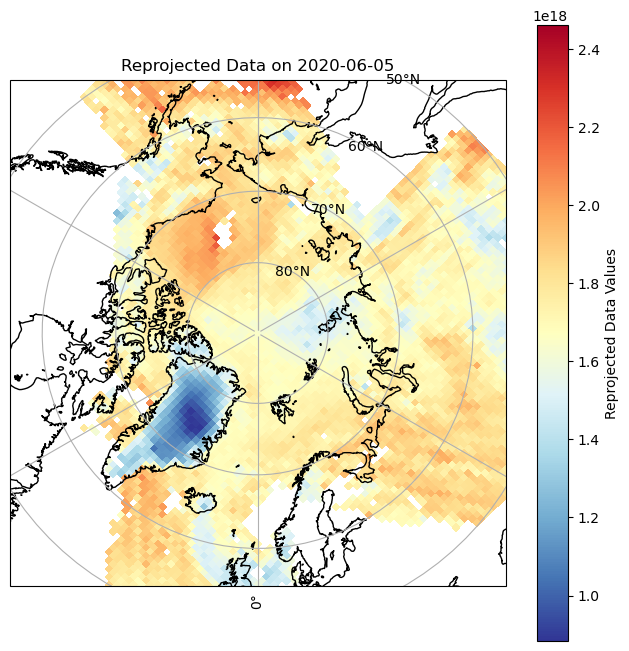

In [18]:
# Define the date, colormap, and value range you want to plot
date_to_plot = '2020-06-05'  # Change this to the desired date
colormap = 'RdYlBu_r'  # Change this to the desired colormap
vmin = 8.836062468900913e+17  # Change this to the desired minimum value
vmax = 2.4613904117282596e+18  # Change this to the desired maximum value

# Call the plotting function with the specified parameters
plot_reprojected_data(reprojected_datasets, area_def, plot_date=date_to_plot, cmap=colormap, vmin=vmin, vmax=vmax)


In [ ]:
# After generating reprojected_datasets_co
import pickle

with open('reprojected_datasets_co.pkl', 'wb') as f:
    pickle.dump(reprojected_datasets, f)
